# |In this notebook we use a two stain SEIR model to forecast for future using predefined parameters of a hidden state models ensemble

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.integrate import odeint
import lmfit
import joblib

In [2]:
sns.set()
%matplotlib inline

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [5]:
from sir_models.models import SEIRHidden, SEIRHiddenTwoStrains
from sir_models.fitters import HiddenCurveFitter
from sir_models.ensemble import EnsembleModel
from sir_models.utils import stepwise, eval_k_days_ahead, smape

# Load data

In [6]:
DATASET_PATH = '/media/boris/ubuntu_data/datasets/covid-19-data/public/data/owid-covid-data.csv'
df = pd.read_csv(DATASET_PATH)
useless_columns = ['iso_code', 'continent',
       'new_vaccinations_smoothed', 'total_vaccinations_per_hundred',
       'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred',
       'new_vaccinations_smoothed_per_million', 'stringency_index',
       'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand',
       'life_expectancy', 'human_development_index', 'total_cases_per_million', 'new_cases_per_million',
       'new_cases_smoothed_per_million', 'total_deaths_per_million',
       'new_deaths_per_million', 'new_deaths_smoothed_per_million', 'icu_patients_per_million', 'hosp_patients_per_million', 'weekly_icu_admissions_per_million',
        'weekly_hosp_admissions_per_million', 'total_tests_per_thousand',  'new_tests_per_thousand', 'new_tests_smoothed_per_thousand', 'icu_patients', 'hosp_patients',
       'weekly_icu_admissions', 'weekly_hosp_admissions',
                   'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'new_vaccinations',
                  ]
df = df.drop(columns=useless_columns)
df.date = pd.to_datetime(df.date)

df = df[df.location == 'Russia']

df['total_deaths'] = df.total_deaths.fillna(0)
df['new_deaths'] = df.new_deaths.fillna(0)
df = df.fillna(0)
df.head().T

,52406,52407,52408,52409,52410
location,Russia,Russia,Russia,Russia,Russia
date,2020-01-31 00:00:00,2020-02-01 00:00:00,2020-02-02 00:00:00,2020-02-03 00:00:00,2020-02-04 00:00:00
total_cases,2,2,2,2,2
new_cases,2,0,0,0,0
new_cases_smoothed,0,0,0,0,0
total_deaths,0,0,0,0,0
new_deaths,0,0,0,0,0
new_deaths_smoothed,0,0,0,0,0
reproduction_rate,0,0,0,0,0
new_tests,0,0,0,0,0


In [7]:
class SEIRHidden_OWID(SEIRHidden):
    def get_fit_params(self, data):
        params = super().get_fit_params(data)
        params['base_population'].value = df.iloc[0].population
        return params


# Load model

In [8]:
ensemble = joblib.load('ensemble_russia.pkl')

In [9]:
ensemble

In [10]:
date_of_first_strain2_contact = '2021-01-10'
df[df.date == date_of_first_strain2_contact].iloc[0]

location                            Russia
date                   2021-01-10 00:00:00
total_cases                    3.36672e+06
new_cases                            22540
new_cases_smoothed                 23281.7
total_deaths                         60963
new_deaths                             440
new_deaths_smoothed                461.857
reproduction_rate                     0.93
new_tests                           383652
total_tests                    9.39636e+07
new_tests_smoothed                  301659
positive_rate                        0.077
tests_per_case                          13
tests_units                tests performed
population                     1.45934e+08
Name: 52751, dtype: object

In [11]:
train_df = df[df.date < date_of_first_strain2_contact]

In [12]:
train_df.tail()

,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,reproduction_rate,new_tests,total_tests,new_tests_smoothed,positive_rate,tests_per_case,tests_units,population
52746,Russia,2021-01-05,3250713.0,23955.0,25255.714,58706.0,503.0,514.143,0.92,268620.0,92338414.0,304934.0,0.083,12.1,tests performed,145934460.0
52747,Russia,2021-01-06,3274615.0,23902.0,24942.429,59137.0,431.0,492.143,0.92,300065.0,92638479.0,284227.0,0.088,11.4,tests performed,145934460.0
52748,Russia,2021-01-07,3297833.0,23218.0,24355.143,59628.0,491.0,479.571,0.92,330412.0,92968891.0,263680.0,0.092,10.8,tests performed,145934460.0
52749,Russia,2021-01-08,3321163.0,23330.0,23886.143,60067.0,439.0,467.000,0.93,268668.0,93237559.0,246918.0,0.097,10.3,tests performed,145934460.0
52750,Russia,2021-01-09,3344175.0,23012.0,23468.143,60523.0,456.0,469.714,0.93,342405.0,93579964.0,271342.0,0.086,11.6,tests performed,145934460.0


# Train predictions

In [13]:
aggregate_states, aggregate_daily, model_states, model_daily_vals, history = ensemble.predict(train_df)
(S, E, I, Iv, R, Rv, D, Dv) = aggregate_states
(new_exposed,
         new_infected_invisible, new_infected_visible,
         new_recovered_invisible,
         new_recovered_visible,
         new_dead_invisible, new_dead_visible) = aggregate_daily 

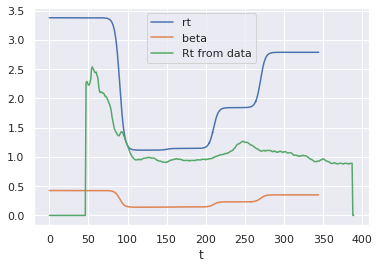

In [14]:
plt.figure()
history.rt.plot()
history.beta.plot()
plt.plot(np.arange(len(df.reproduction_rate)), df.reproduction_rate, label='Rt from data')
plt.legend()
plt.show()

# Future forecast - one strain

In [15]:
train_t = np.arange(len(train_df))

In [16]:
future_dates = pd.date_range(start=date_of_first_strain2_contact, periods=365//2)
future_t = np.max(train_t) + np.arange(len(future_dates))

assert len(future_dates) == len(future_t)

In [17]:
future_dates

DatetimeIndex(['2021-01-10', '2021-01-11', '2021-01-12', '2021-01-13',
               '2021-01-14', '2021-01-15', '2021-01-16', '2021-01-17',
               '2021-01-18', '2021-01-19',
               ...
               '2021-07-01', '2021-07-02', '2021-07-03', '2021-07-04',
               '2021-07-05', '2021-07-06', '2021-07-07', '2021-07-08',
               '2021-07-09', '2021-07-10'],
              dtype='datetime64[ns]', length=182, freq='D')

In [18]:
future_t

array([344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356,
       357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369,
       370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382,
       383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395,
       396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408,
       409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421,
       422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434,
       435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447,
       448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460,
       461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473,
       474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486,
       487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499,
       500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512,
       513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 52

In [19]:
future_initial_conds = (S[-1], E[-1], I[-1], Iv[-1], R[-1], Rv[-1], D[-1], Dv[-1])

In [20]:
(future_aggregate_states, 
 future_aggregate_daily, 
 future_model_states, 
 future_model_daily_vals, 
 future_history) = ensemble.predict(t=future_t, initial_conditions=future_initial_conds)

(future_S, future_E, future_I, future_Iv, future_R, future_Rv, future_D, future_Dv) = future_aggregate_states

(future_new_exposed,
         future_new_infected_invisible, future_new_infected_visible,
         future_new_recovered_invisible,
         future_new_recovered_visible,
         future_new_dead_invisible, future_new_dead_visible) = future_aggregate_daily

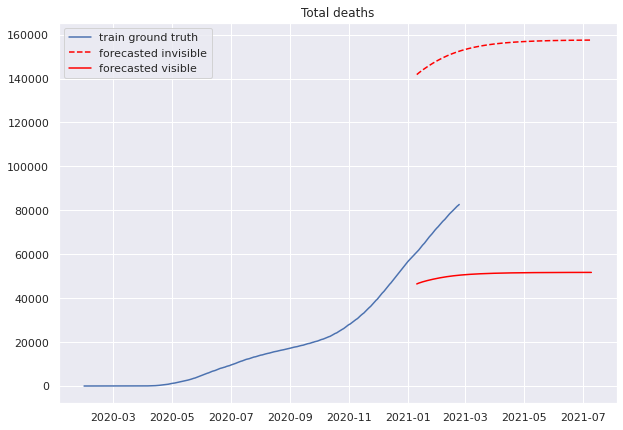

In [21]:
plt.figure(figsize=(10, 7))
plt.plot(df.date, df['total_deaths'], label='train ground truth')
plt.plot(future_dates, future_D, label='forecasted invisible', color='red', linestyle='dashed')
plt.plot(future_dates, future_Dv, label='forecasted visible', color='red')
plt.legend()
plt.title('Total deaths')
plt.show()

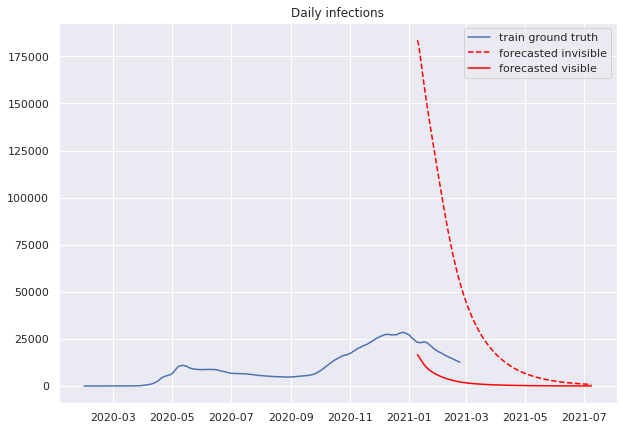

In [22]:
plt.figure(figsize=(10, 7))
plt.plot(df.date, df['new_cases_smoothed'], label='train ground truth')

plt.plot(future_dates[:-1], future_new_infected_invisible, label='forecasted invisible', color='red', linestyle='dashed')
plt.plot(future_dates[:-1], future_new_infected_visible, label='forecasted visible', color='red')
plt.legend()
plt.title('Daily infections')
plt.show()

# Extrapolate with two stains

In [23]:
ensemble

In [24]:
ensemble.models[0].params['t300_q'].value

0.5

In [25]:
strain2_models = [SEIRHiddenTwoStrains.from_strain_one_model(model) for model in ensemble.models]

# for model in strain2_models:
#     model.params['t300_q'].value = 0.7
ensemble_strain2 = EnsembleModel(models=strain2_models, weights=ensemble.weights)

In [26]:
strain2_models[0].params['beta2_mult'], strain2_models[0].params['t300_q'].value

(<Parameter 'beta2_mult', value=1.5 (fixed), bounds=[1:2]>, 0.5)

In [27]:
new_stain_ratio = 0.01

# E2_0 = 0
# I2_0 = 1/strain2_models[-1].params['pi'].value
# Iv2_0 = 1

E2_0 = E[-1] * new_stain_ratio
E1_0 = E[-1] *  (1-new_stain_ratio)
Iv2_0 = Iv[-1] * new_stain_ratio
Iv1_0 = Iv[-1] *  (1-new_stain_ratio)
I2_0 = I[-1] * new_stain_ratio
I1_0 = I[-1] *  (1-new_stain_ratio)

future_initial_conds_two_strain = (S[-1]-1, E1_0, I1_0, Iv1_0, E2_0, I2_0, Iv2_0, R[-1], Rv[-1], D[-1], Dv[-1])
I2_0, Iv2_0

(12117.817693332103, 465.2601329402614)

In [28]:
(future_aggregate_states, 
 future_aggregate_daily, 
 future_model_states, 
 future_model_daily_vals, 
 future_history) = ensemble_strain2.predict(t=future_t, initial_conditions=future_initial_conds_two_strain)

(future_S, future_E1, future_I1, future_Iv1, future_E2, future_I2, future_Iv2, future_R, future_Rv, future_D, future_Dv) = future_aggregate_states

(future_new_exposed,
         future_new_infected_invisible, future_new_infected_visible,
         future_new_recovered_invisible,
         future_new_recovered_visible,
         future_new_dead_invisible, future_new_dead_visible) = future_aggregate_daily

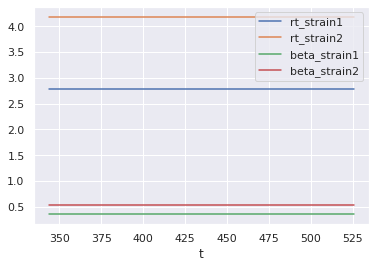

In [29]:
plt.figure()
future_history.rt_strain1.plot()
future_history.rt_strain2.plot()

future_history.beta_strain1.plot()
future_history.beta_strain2.plot()
plt.legend()
plt.show()

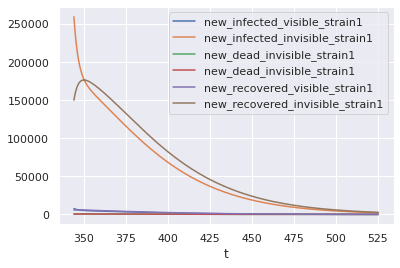

In [30]:
future_history.new_infected_visible_strain1.plot()
future_history.new_infected_invisible_strain1.plot()
future_history.new_dead_invisible_strain1.plot()
future_history.new_dead_invisible_strain1.plot()
future_history.new_recovered_visible_strain1.plot()
future_history.new_recovered_invisible_strain1.plot()
plt.legend()

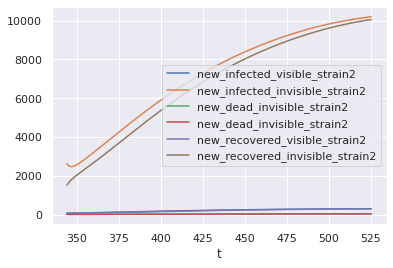

In [31]:
future_history.new_infected_visible_strain2.plot()
future_history.new_infected_invisible_strain2.plot()
future_history.new_dead_invisible_strain2.plot()
future_history.new_dead_invisible_strain2.plot()
future_history.new_recovered_visible_strain2.plot()
future_history.new_recovered_invisible_strain2.plot()
plt.legend()

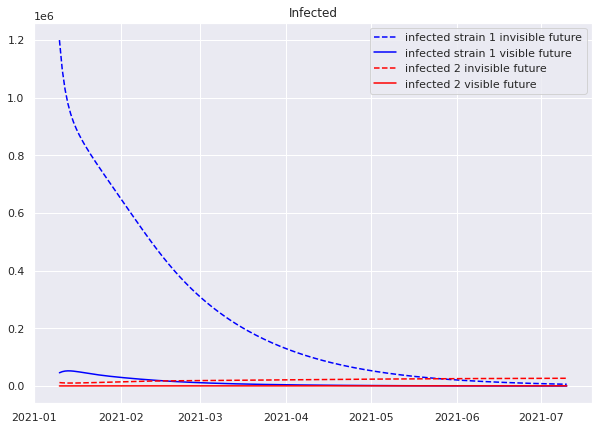

In [32]:
plt.figure(figsize=(10, 7))
plt.plot(future_dates, future_I1, label='infected strain 1 invisible future',  color='blue', linestyle='--')
plt.plot(future_dates, future_Iv1, label='infected strain 1 visible future', color='blue')
plt.plot(future_dates, future_I2, label='infected 2 invisible future', color='red', linestyle='--')
plt.plot(future_dates, future_Iv2, label='infected 2 visible future', color='red')

plt.legend()
plt.title('Infected')
plt.show()

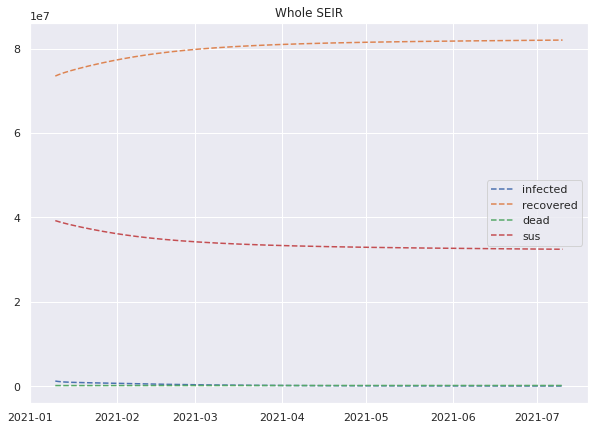

In [33]:
plt.figure(figsize=(10, 7))
plt.plot(future_dates, future_I1 + future_I2, label='infected', linestyle='--')
plt.plot(future_dates, future_R, label='recovered', linestyle='--')
plt.plot(future_dates, future_D, label='dead', linestyle='--')
plt.plot(future_dates, future_S, label='sus', linestyle='--')
plt.legend()
plt.title('Whole SEIR')
plt.show()

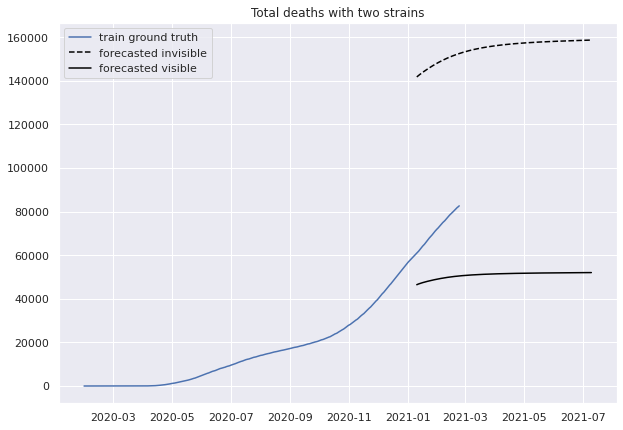

In [34]:
plt.figure(figsize=(10, 7))
plt.plot(df.date, df['total_deaths'], label='train ground truth')
plt.plot(future_dates, future_D, label='forecasted invisible', color='black', linestyle='dashed')
plt.plot(future_dates, future_Dv, label='forecasted visible', color='black')
plt.legend()
plt.title('Total deaths with two strains')
plt.show()